# Diplomacy Lie Detection - Baseline Model

This notebook implements a baseline model for the Diplomacy lie detection task based on the 2020 ACL Diplomacy project. We'll use a Bag of Words approach with Logistic Regression, which provides a solid baseline for text classification tasks.

## Setup and Imports

In [12]:
# Importing the required libraries
import jsonlines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import spacy
from spacy.lang.en import English
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Initialize spaCy for tokenization
try:
    temp = English()
    print("SpaCy English model loaded successfully.")
except Exception as e:
    print(f"Error loading spaCy English model: {e}")
    print("Try installing with: python -m spacy download en_core_web_sm")

SpaCy English model loaded successfully.


## Helper Functions

In [14]:
# Checking to see if the given token is a number or not
def check_if_number(token):
    try:
        float(token)
        return True
    except ValueError:
        return False

# Defining the function to tokenize the input text using the Spacy tokenizer
def spacy_tokenizer(text):
    tokenized_text = temp(text)
    return [token.text if not check_if_number(token.text) else '_NUM_' for token in tokenized_text]

In [15]:
# Function to aggregate data from dialogues into individual messages
def collate_dialogues(dataset):

    # Initializing lists to store the messages, receiver labels, sender labels and power scores for each message in each dialogue
    messages = []
    receiver_decption_labels = []
    sender_deception_labels = []
    power_score_deltas = []

    # Iterating over all the dialogues in the dataset
    for dialog_messages in dataset:

        # Extracting and collating the messages, receiver labels, sender labels, and power scores for each dialogue
        messages.extend(dialog_messages['messages'])
        receiver_decption_labels.extend(dialog_messages['receiver_labels'])
        sender_deception_labels.extend(dialog_messages['sender_labels'])
        power_score_deltas.extend(dialog_messages['game_score_delta'])
    
    # Initializing an empty dictionary to store the collated messages
    collated_dictionary = []

    # Iterating over the collated data points
    for i, item in enumerate(messages):

        # Creating a new dicitionary entry for each data point in the collated lists
        collated_dictionary.append({
            'message': item, 
            'sender_annotation': sender_deception_labels[i], 
            'receiver_annotation': receiver_decption_labels[i], 
            'score_delta': int(power_score_deltas[i])
        })
    
    # Returning the dictionary containing all the collated data points
    return collated_dictionary

In [16]:
# Converting the deception lables to binary labels
def convert_to_binary(dataset, task="SENDER", use_power=True):

    # Initializing the list to store the binary deception label data for all messages
    total_binary_data = []
    
    for message in dataset:
        # Skipping unannotated instances for RECEIVER task
        if message['receiver_annotation'] != True and message['receiver_annotation'] != False:
            if task == "SENDER":
                pass  # Keeping all for the SENDER task
            elif task == "RECEIVER":
                continue  # Skipping for the RECEIVER task
        
        # Initializing the list to store the binary deception label data for the current message
        cur_binary_data = []
        
        # Add power features if enabled (severe power skew)
        if use_power:
            # Strong positive power delta
            if message['score_delta'] > 4:
                cur_binary_data.append(1)
            else:
                cur_binary_data.append(0)
            
            # Strong negative power delta
            if message['score_delta'] < -4:
                cur_binary_data.append(1)
            else:
                cur_binary_data.append(0)

        # Getting the deception label based on the given task
        if task == "SENDER":
            annotation = 'sender_annotation'
        elif task == "RECEIVER":
            annotation = 'receiver_annotation'
            
        # Adding the deception label to the current message's binary data
        if message[annotation] == False:
            cur_binary_data.append(0)  # 0 for False (lie)
        else:
            cur_binary_data.append(1)  # 1 for True (truth)

        total_binary_data.append(cur_binary_data)
    return total_binary_data

In [17]:
# Given the dataset, splitting the dataset into features (X) and labels (y)
def split_xy(data):

    # Initializing lists to store the features and labels
    X, Y = [], []

    # Iterating over each line in the given dataset
    for data_point in data:

        # Extracting the features from the current line of the dataset
        features = data_point[:len(data_point)-1]

        # Extracting the label from the current line of the dataset
        label = data_point[len(data_point)-1]

        # Adding the extracted features and label to the respective lists
        X.append(features)
        Y.append(label)

    # Returning the final lists of extracted features and labels
    return (X, Y)

## Loading the Data

Loading the required training and testing datasets from the "Data/" directory's train.jsonl and test.jsonl files.

In [18]:
# Setting the data path
dataset_path = 'Data/'

try:
    # Opening the train.jsonl file and loading the training dataset
    with jsonlines.open(dataset_path+'train.jsonl', 'r') as f:
        training_dataset = list(f)

    print("Successfully loaded the training dataset!")
    print("Tarining dataset samples: "+str(len(training_dataset)))

    # Opening the test.jsonl file and loading the training dataset
    with jsonlines.open(dataset_path+'test.jsonl', 'r') as f:
        testing_dataset = list(f)
    
    print("Successfully loaded the training dataset!")
    print("Tarining dataset samples: "+str(len(testing_dataset)))
except Exception as e:
    print(f"Error loading data: {e}")
    print("Make sure the data files (train.jsonl and test.jsonl) are in the 'data/' directory.")

Successfully loaded the training dataset!
Tarining dataset samples: 189
Successfully loaded the training dataset!
Tarining dataset samples: 42


## Examining the Training Dataset

In [19]:
# Printing a data point from the dataset for debugging and understanding the structure and content of each data point
print("Selecting the first dialogue!")
print(f"Number of messages in this dialogue: {len(training_dataset[0]['messages'])}")
for i, message in enumerate(training_dataset[0]['messages'][:10]):
    print(f"\nMessage {i+1}:")
    print("-----------")
    print("Message Content:")
    print(message)
    print("-----------")
    print(f"Sender Deception Label: {training_dataset[0]['sender_labels'][i]}")
    print("-----------")
    print(f"Receiver Deception Label: {training_dataset[0]['receiver_labels'][i]}")
    print("-----------")
    print(f"Power score delta: {training_dataset[0]['game_score_delta'][i]}")
    print("--------------------------------------------------------------------------------------------")

Selecting the first dialogue!
Number of messages in this dialogue: 321

Message 1:
-----------
Message Content:
Germany!

Just the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. 

So...do I suggest it?

I’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.

What is your appetite like for unusual and crazy?
-----------
Sender Deception Label: True
-----------
Receiver Deception Label: True
-----------
Power score delta: 0
--------------------------------------------------------------------------------------------

Message 2:
-----------
Message Content:
You've whet my appetite, Italy. What's the suggestion?
-----------
Sender Deception Label: True
-----------
Receiver Deception Label: True
-----------
Power score delt

## Class Distribution Analysis

Sender Deception Label Class Distribution:
Sender Truth Label Percentage: 12541 (95.5%)
Sender Lie Label Percentage: 591 (4.5%)
No annotation: 0

Receiver Deception Label Class Distribution:
Receiver Truth Label Percentage: 11459 (95.3%)
Receiver Truth Label Percentage: 566 (4.7%)
No annotation: 1107


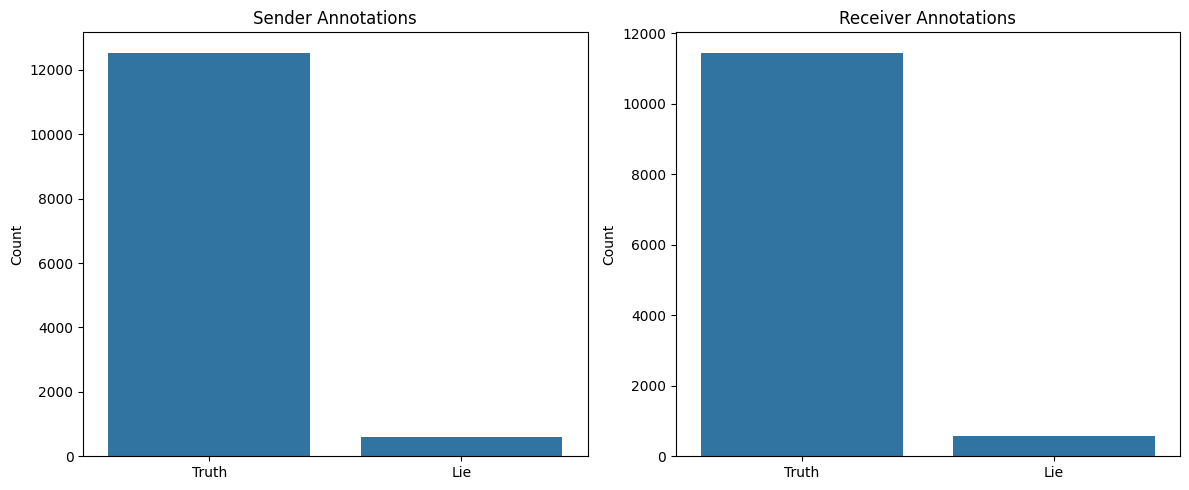

In [20]:
# Collating the data points (messages) across all dialogues in the dataset and creating a new dictionary for these collated messages
aggregated_train = collate_dialogues(training_dataset)

# Counting the sender deception labels
n_sender_true = sum(1 for msg in aggregated_train if msg['sender_annotation'] == True)
n_sender_false = sum(1 for msg in aggregated_train if msg['sender_annotation'] == False)
n_sender_unlabelled = sum(1 for msg in aggregated_train if msg['sender_annotation'] != True and msg['sender_annotation'] != False)

# Count receiver annotations
n_receiver_true = sum(1 for msg in aggregated_train if msg['receiver_annotation'] == True)
n_receiver_false = sum(1 for msg in aggregated_train if msg['receiver_annotation'] == False)
n_receiver_unlabelled = sum(1 for msg in aggregated_train if msg['receiver_annotation'] != True and msg['receiver_annotation'] != False)

# Printing the class distribution statistics for both sender and receiver deception labels
print("Sender Deception Label Class Distribution:")
print(f"Sender Truth Label Percentage: {n_sender_true} ({n_sender_true/(n_sender_true+n_sender_false)*100:.1f}%)")
print(f"Sender Lie Label Percentage: {n_sender_false} ({n_sender_false/(n_sender_true+n_sender_false)*100:.1f}%)")
print(f"No annotation: {n_sender_unlabelled}")
print()
print("Receiver Deception Label Class Distribution:")
print(f"Receiver Truth Label Percentage: {n_receiver_true} ({n_receiver_true/(n_receiver_true+n_receiver_false)*100:.1f}%)")
print(f"Receiver Truth Label Percentage: {n_receiver_false} ({n_receiver_false/(n_receiver_true+n_receiver_false)*100:.1f}%)")
print(f"No annotation: {n_receiver_unlabelled}")

# Visualizing the class distributions for the sender and receiver decpetion labels
plt.figure(figsize=(12, 5))

# Plot for the sender's deception labels
plt.subplot(1, 2, 1)
sns.barplot(x=['Truth', 'Lie'], y=[n_sender_true, n_sender_false])
plt.title('Sender Annotations')
plt.ylabel('Count')

# Plot for the receiver's deception labels
plt.subplot(1, 2, 2)
sns.barplot(x=['Truth', 'Lie'], y=[n_receiver_true, n_receiver_false])
plt.title('Receiver Annotations')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Model Training and Evaluation Function

In [21]:
# Defining the function to handle the model training and evaluation tasks for the given train and test datasets
def train_and_evaluate(training_dataset, testing_dataset, task="SENDER", use_power=True):
    print(f"\n{'='*60}")
    print(f"Training model for {task} task with power={use_power}")
    print(f"{'='*60}\n")
    
    # Collating the messages for all dialogues in the given training dataset to create a new collated training dataset
    training_collated_dataset = collate_dialogues(training_dataset)

    # Collating the messages for all dialogues in the given testing dataset to create a new collated testing dataset
    testing_collated_dataset = collate_dialogues(testing_dataset)
    
    # Creating the count vectorizer object which will be used for feature extraction - using 'English' stopwords
    vectorizer = CountVectorizer(
        tokenizer=spacy_tokenizer, # Specifying the tokenzier to be Spacy Tokenizer
        stop_words='english',  # Using predefined English stopwords
        strip_accents='unicode'
    )
    
    # Preparing the training dataset
    if task == "SENDER":
        corpus = [message['message'].lower() for message in training_collated_dataset]
    elif task == "RECEIVER": # For receivers, dropping all missing annotations        
        corpus = [message['message'].lower() for message in training_collated_dataset if message['receiver_annotation'] == True or message['receiver_annotation'] == False]
    
    # Transforming the collated and preprocessed training corpus to BoW features
    training_features = vectorizer.fit_transform(corpus)
 
    # Creating the count vectorizer object for the testing dataset using the same vocabulary as generated from the training dataset's vectorizer vocabulary
    test_vectorizer = CountVectorizer(
        tokenizer=spacy_tokenizer, # Specifying the tokenzier to be Spacy Tokenizer
        vocabulary=vectorizer.vocabulary_,  # Specifying the use of the same vocabulary as the training dataset's vectorizer
        stop_words='english',  # Using predefined English stopwords
        strip_accents='unicode'
    )
    
    # Preparing the testing dataset
    if task == "SENDER":
        test_corpus = [message['message'].lower() for message in testing_collated_dataset]
    elif task == "RECEIVER": # For receivers, drop all missing annotations        
        test_corpus = [message['message'].lower() for message in testing_collated_dataset if message['receiver_annotation'] == True or message['receiver_annotation'] == False]
    
    # Transforming the collated and preprocessed testing corpus to BoW features
    testing_features = test_vectorizer.fit_transform(test_corpus)

    # Getting the binary labels for the training and testing datasets
    training_binary_data = convert_to_binary(training_collated_dataset, task, use_power)
    testing_binary_data = convert_to_binary(testing_collated_dataset, task, use_power)
    
    # Splitting the training and testing datasets' binary labels into power features and labels
    train_split_features, train_split_labels = split_xy(training_binary_data)
    test_split_features, test_split_labels = split_xy(testing_binary_data)

    # Appending the power features to both the original training and testing features generated by the Count Vectorizer if the power is to be used for training the model
    if use_power:
        new_training_features = np.append(training_features.toarray(), train_split_features, axis=1)
        new_testing_features = np.append(testing_features.toarray(), test_split_features, axis=1)
        
        # Converting feature matrices for the training and testing datasets back to sparse format
        training_features = csr_matrix(new_training_features)
        testing_features = csr_matrix(new_testing_features)
    
    # Printing the shape of the training and testing final feature matrix
    print(f"Training features shape: {training_features.shape}")
    print(f"Testing features shape: {testing_features.shape}")

    # Printing the number of Truths and Lies in the binary label dataset for the training dataset
    print(f"Label distribution in training labels: Truth={sum(train_split_labels)}, Lie={len(train_split_labels)-sum(train_split_labels)}")
    
    # Training the logistic regression model with balanced class weights (to handle imbalanced datasets) using 1000 epochs
    logmodel = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    logmodel.fit(training_features, train_split_labels)
    
    # Making the predictions for the testing dataset using the trained Logistic Regression Model
    predictions = logmodel.predict(testing_features)
    
    # Printing the classification report for the testing dataset
    print("\nClassification Report:")
    report = classification_report(test_split_labels, predictions, digits=3, output_dict=True)
    print(classification_report(test_split_labels, predictions, digits=3))
    
    # Analysing the feature importance
    if use_power:
        # Handle the case where power features are included
        feature_names = list(vectorizer.get_feature_names_out()) + ['power_high', 'power_low']
    else:
        feature_names = list(vectorizer.get_feature_names_out())
    
    # Getting the coefficients for each of the feature vectors from the trained LR model
    coef = logmodel.coef_[0]
    
    # Creating a DataFrame to store the feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': coef
    })
    
    # Sorting the created dataframe in descending order by absolute feature importance
    feature_importance['abs_importance'] = feature_importance['importance'].abs()
    feature_importance = feature_importance.sort_values('abs_importance', ascending=False)
    
    # Printing the top 10 features that indicate a lie from the sorted list of features according to absolute importance
    print("\nTop 10 features indicating a lie (negative coefficients):")
    lie_features = feature_importance[feature_importance['importance'] < 0].head(10)
    print(lie_features[['feature', 'importance']])
    
    # Printing the top 10 features that indicate a truth from the sorted list of features according to absolute importance
    print("\nTop 10 features indicating truth (positive coefficients):")
    truth_features = feature_importance[feature_importance['importance'] > 0].head(10)
    print(truth_features[['feature', 'importance']])
    
    # Plotting the most important features that help identify truths and lies
    plt.figure(figsize=(12, 8))
    top_features = pd.concat([lie_features.head(10), truth_features.head(10)])
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top Features by Importance ({task} Task, Power={use_power})')
    plt.axvline(x=0, color='black', linestyle='-')
    plt.tight_layout()
    plt.show()
    
    # Returning the classification report on the testing dataset, the trained LR model for the given task, the trained Count Vectorizer object and the feature importance matrix for further processing and debugging
    return report, logmodel, vectorizer, feature_importance

## Training and Evaluating the Models

We'll train four different models:
1. Sender task with power features
2. Sender task without power features
3. Receiver task with power features
4. Receiver task without power features


Training model for SENDER task with power=True

Training features shape: (13132, 7846)
Testing features shape: (2741, 7846)
Label distribution in training labels: Truth=12541, Lie=591

Classification Report:
              precision    recall  f1-score   support

           0      0.160     0.250     0.195       240
           1      0.924     0.874     0.898      2501

    accuracy                          0.819      2741
   macro avg      0.542     0.562     0.547      2741
weighted avg      0.857     0.819     0.837      2741


Top 10 features indicating a lie (negative coefficients):
           feature  importance
7003      tracking   -3.192334
5620    resistance   -3.102346
3517  inconclusive   -2.974259
273            aei   -2.965716
7686            ws   -2.949904
2442          exit   -2.864967
4563           nrg   -2.619565
5610      requires   -2.584495
6602       succeed   -2.583271
3618        intent   -2.578935

Top 10 features indicating truth (positive coefficients):
     

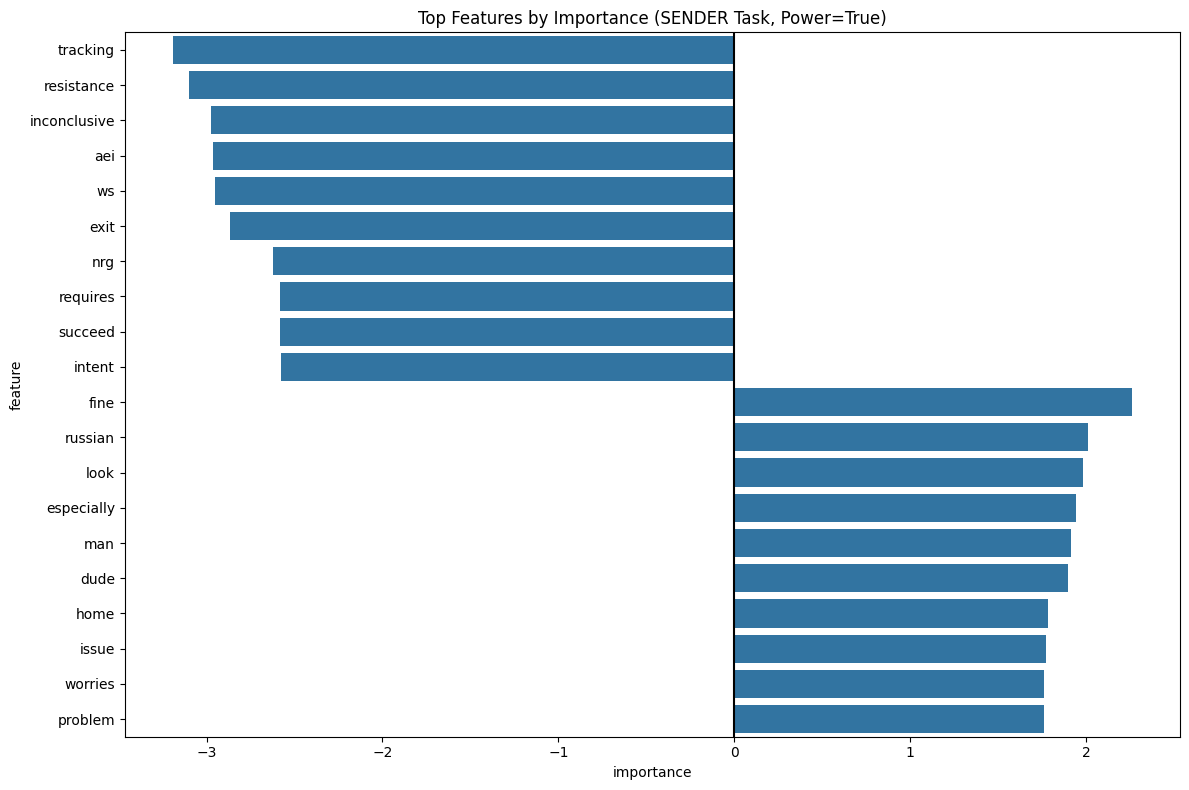

In [22]:
# SENDER task with power
sender_report_power, sender_model_power, sender_vectorizer_power, sender_features_power = train_and_evaluate(training_dataset, testing_dataset, task="SENDER", use_power=True)


Training model for SENDER task with power=False

Training features shape: (13132, 7844)
Testing features shape: (2741, 7844)
Label distribution in training labels: Truth=12541, Lie=591

Classification Report:
              precision    recall  f1-score   support

           0      0.148     0.225     0.179       240
           1      0.922     0.876     0.898      2501

    accuracy                          0.819      2741
   macro avg      0.535     0.550     0.538      2741
weighted avg      0.854     0.819     0.835      2741


Top 10 features indicating a lie (negative coefficients):
           feature  importance
7003      tracking   -3.211193
5620    resistance   -3.089447
3517  inconclusive   -3.011473
273            aei   -2.958355
7686            ws   -2.907126
2442          exit   -2.874117
4563           nrg   -2.621734
3618        intent   -2.576522
6602       succeed   -2.573247
5610      requires   -2.570181

Top 10 features indicating truth (positive coefficients):
    

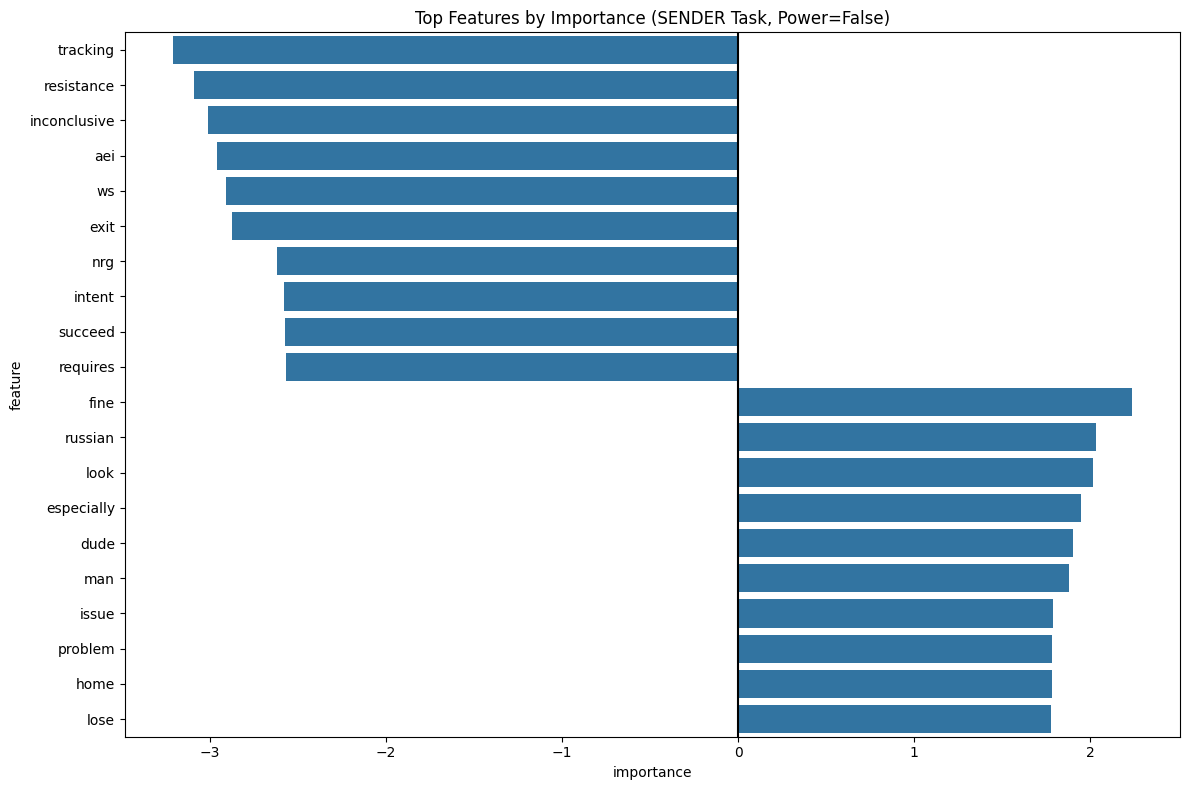

In [23]:
# SENDER task without power
sender_report_no_power, sender_model_no_power, sender_vectorizer_no_power, sender_features_no_power = train_and_evaluate(training_dataset, testing_dataset, task="SENDER", use_power=False)


Training model for RECEIVER task with power=True

Training features shape: (12025, 7575)
Testing features shape: (2475, 7575)
Label distribution in training labels: Truth=11459, Lie=566

Classification Report:
              precision    recall  f1-score   support

           0      0.102     0.242     0.144       165
           1      0.940     0.848     0.891      2310

    accuracy                          0.807      2475
   macro avg      0.521     0.545     0.518      2475
weighted avg      0.884     0.807     0.842      2475


Top 10 features indicating a lie (negative coefficients):
              feature  importance
2503           feisty   -2.941535
3398  inconsequential   -2.849471
6763         tracking   -2.666310
3220            homie   -2.654300
5323          refuses   -2.588178
4258                n   -2.538225
6051            sniff   -2.526424
1963       dishonesty   -2.405165
5065           proper   -2.403902
2015             dmzd   -2.383636

Top 10 features indicating t

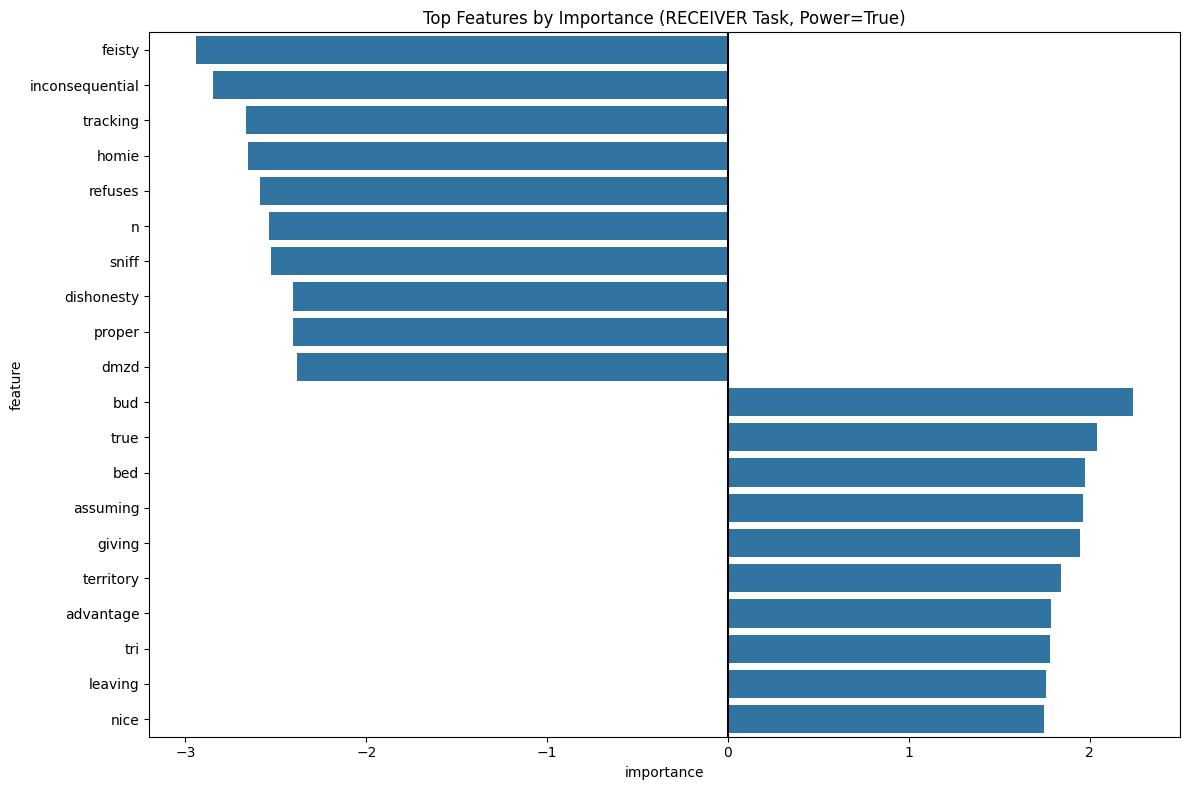

In [24]:
# RECEIVER task with power
receiver_report_power, receiver_model_power, receiver_vectorizer_power, receiver_features_power = train_and_evaluate(training_dataset, testing_dataset, task="RECEIVER", use_power=True)


Training model for RECEIVER task with power=False

Training features shape: (12025, 7573)
Testing features shape: (2475, 7573)
Label distribution in training labels: Truth=11459, Lie=566

Classification Report:
              precision    recall  f1-score   support

           0      0.103     0.236     0.143       165
           1      0.940     0.853     0.894      2310

    accuracy                          0.812      2475
   macro avg      0.521     0.545     0.519      2475
weighted avg      0.884     0.812     0.844      2475


Top 10 features indicating a lie (negative coefficients):
              feature  importance
2503           feisty   -2.912184
3398  inconsequential   -2.829099
6763         tracking   -2.656897
3220            homie   -2.628112
5323          refuses   -2.596628
6051            sniff   -2.506292
4258                n   -2.497472
2015             dmzd   -2.403828
1963       dishonesty   -2.375821
5065           proper   -2.372162

Top 10 features indicating 

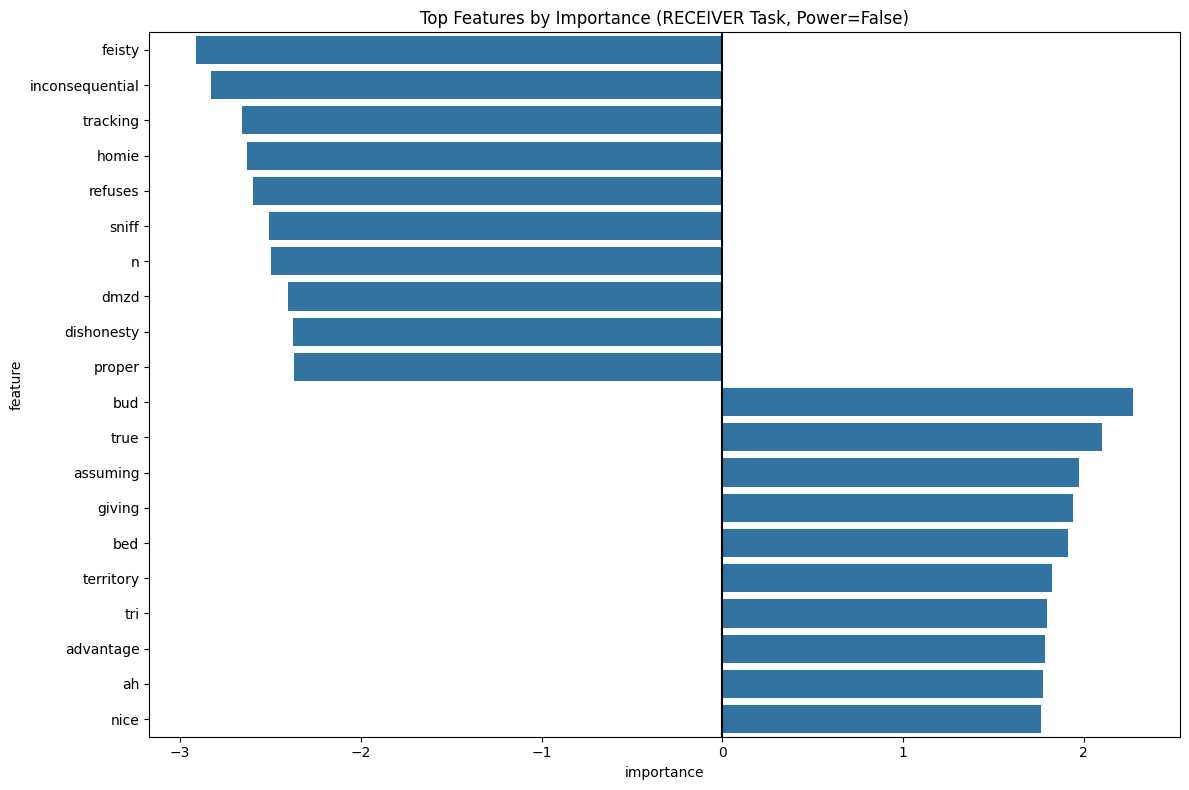

In [25]:
# RECEIVER task without power
receiver_report_no_power, receiver_model_no_power, receiver_vectorizer_no_power, receiver_features_no_power = train_and_evaluate(training_dataset, testing_dataset, task="RECEIVER", use_power=False)

## Analysing and Comparing Model Results

Model Comparison:
            Model  Macro F1    Lie F1  Truth F1
0    Sender+Power  0.546708  0.195122  0.898295
1          Sender  0.538303  0.178512  0.898093
2  Receiver+Power  0.517522  0.143627  0.891418
3        Receiver  0.518809  0.143382  0.894235


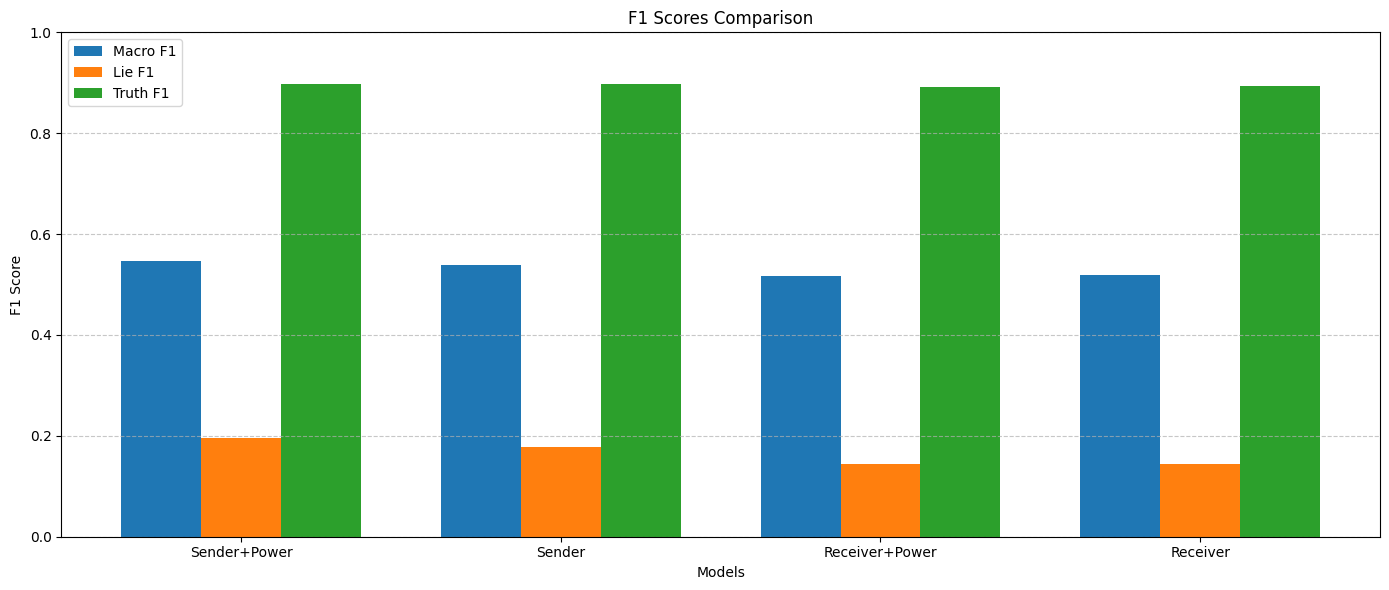

In [26]:
# Comparing the F1 scores for different models

# Initializing the list to store all the types of models we trained before
models = ['Sender+Power', 'Sender', 'Receiver+Power', 'Receiver']

# Initializing the list to store the macro average F1-Score for all four types of models we trained above
f1_macro = [
    sender_report_power['macro avg']['f1-score'],
    sender_report_no_power['macro avg']['f1-score'],
    receiver_report_power['macro avg']['f1-score'],
    receiver_report_no_power['macro avg']['f1-score']
]

# Initializing the list to store the F1-Score for the Lie labels for all four types of models we trained above
f1_lie = [
    sender_report_power['0']['f1-score'],  # 0 is lie (False) in our case
    sender_report_no_power['0']['f1-score'],
    receiver_report_power['0']['f1-score'],
    receiver_report_no_power['0']['f1-score']
]

# Initializing the list to store the F1-Score for the Truth labels for all four types of models we trained above
f1_truth = [
    sender_report_power['1']['f1-score'],  # 1 is truth (True) in our case
    sender_report_no_power['1']['f1-score'],
    receiver_report_power['1']['f1-score'],
    receiver_report_no_power['1']['f1-score']
]

# Creating a DataFrame for comparison by consolidating all the data points for the four models
comparison_df = pd.DataFrame({
    'Model': models,
    'Macro F1': f1_macro,
    'Lie F1': f1_lie,
    'Truth F1': f1_truth
})

# Printing the consolidated dataframe for quick analysis
print("Model Comparison:")
print(comparison_df)

# Plotting the comparison using a bar graph for each of the four models for more visualization
plt.figure(figsize=(14, 6))
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, f1_macro, width, label='Macro F1')
plt.bar(x, f1_lie, width, label='Lie F1')
plt.bar(x + width, f1_truth, width, label='Truth F1')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Scores Comparison')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Use the Model to Predict on New Data

Here's how you can use the trained model to predict whether a new message contains a lie:

In [27]:
# Defining the function to evaluate any the truthfulness of any given message using any one of the above trained models
def predict_lie(message, model, vectorizer, task="SENDER", use_power=True, power_delta=0):
    """Predict whether a message contains a lie using the trained model"""
    # Vectorizing the message using the saved model's training dataset vectorizer
    message_features = vectorizer.transform([message.lower()])
    
    # Adding power features to the total feature matrix for the message if requested
    if use_power:
        power_features = []
        if power_delta > 4:
            power_features.append(1)
        else:
            power_features.append(0)
        if power_delta < -4:
            power_features.append(1)
        else:
            power_features.append(0)
            
        # Combining the power features with the count vectorizer's features to get the final feature vector for the message and converting it back to a sparse format
        combined_features = np.append(message_features.toarray(), [power_features], axis=1)
        message_features = csr_matrix(combined_features)
    
    # Making the predictions using the trained model
    prediction = model.predict(message_features)[0]
    probabilities = model.predict_proba(message_features)[0]
    
    # Returning the prediction results for the given message
    return {
        'is_lie': prediction == 0,  # 0 means lie
        'confidence': probabilities[0] if prediction == 0 else probabilities[1], # Confidence of the trained model in the predicted deception label
        'prediction': 'Lie' if prediction == 0 else 'Truth', # Prediction Label
        'probabilities': { # Returning the probability of that message being a truth or a lie
            'lie': probabilities[0],
            'truth': probabilities[1]
        }
    }

# Using some hypothetical new messages to test the model
messages_to_evaluate = [
    "I promise I won't attack your territory next turn.",
    "Let's form an alliance against Germany.",
    "I'm moving my troops to defend my own border, not to attack you.",
    "I need your help to defeat Russia, and then we'll share the spoils."
]

# Using the best model (based on the comparison done above)
best_model = sender_model_power
best_vectorizer = sender_vectorizer_power

# Making the predictions using the best trained model for each of the new messages
for i, message in enumerate(messages_to_evaluate):
    result = predict_lie(message, best_model, best_vectorizer, task="SENDER", use_power=True)
    print(f"\nMessage {i+1}: \n{message}")
    print(f"Model's Prediction: {result['prediction']} (Model's Confidence in Prediction: {result['confidence']:.2f})")
    print(f"Probability that the message is a Lie: {result['probabilities']['lie']:.2f} || Probabiluty that the message is a Truth: {result['probabilities']['truth']:.2f}")


Message 1: 
I promise I won't attack your territory next turn.
Model's Prediction: Truth (Model's Confidence in Prediction: 0.86)
Probability that the message is a Lie: 0.14 || Probabiluty that the message is a Truth: 0.86

Message 2: 
Let's form an alliance against Germany.
Model's Prediction: Lie (Model's Confidence in Prediction: 0.52)
Probability that the message is a Lie: 0.52 || Probabiluty that the message is a Truth: 0.48

Message 3: 
I'm moving my troops to defend my own border, not to attack you.
Model's Prediction: Lie (Model's Confidence in Prediction: 0.85)
Probability that the message is a Lie: 0.85 || Probabiluty that the message is a Truth: 0.15

Message 4: 
I need your help to defeat Russia, and then we'll share the spoils.
Model's Prediction: Lie (Model's Confidence in Prediction: 0.94)
Probability that the message is a Lie: 0.94 || Probabiluty that the message is a Truth: 0.06


## Conclusion

In this notebook, we implemented baseline models for lie detection in the Diplomacy game using a Bag of Words approach with Logistic Regression. We compared different configurations:

1. Sender vs. Receiver perspective
2. With vs. without power features

Our analysis shows:
- The impact of including power features on model performance
- The difference between sender and receiver perspectives
- The most important linguistic features for lie detection

These baseline models can serve as a foundation for more advanced approaches such as neural networks or transformer-based models, which may capture more complex patterns in deceptive language.